<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

<br>

# <font color="#76b900" style="text-align:center;">**Notebook 6:** Embedding Models and Semantic Reasoning</font>

<br>

In our previous notebook, we progressed our efforts towards the large document domain and learned how to apply our same techniques for dealing with a large base of relevant content! Along the way, we noted some challenges — specifically in the area of on-the-fly interpretation — that we still couldn't solve with our existing techniques. We will use this notebook to shift our focus to a different approach to help us approach this objective: **embedding models**.


<br>

### **Learning Objectives:**

- Familiarize yourself with embeddings — numerical representations of words, phrases, or documents — and how they enable deep learning models to process semantic meanings.

- Learn how to apply these embedding models in large-scale document processing, enhancing our existing methods of document summarization and knowledge extraction.

<br>

### **Questions To Think About:**

- How do embeddings contribute to a deeper understanding of document chunks, especially when dealing with inconsistencies or text conversion issues?

- How do we strike the right balance between detail and computational efficiency with embedding models? Are there ways to rephrase or canonicalize (standardize) your queries with LLMs? Alternatively, can we fine-tune them for specialized tasks?

- How can embedding models complement the running state chains and knowledge bases we've previously developed? *(Topic of next the notebook)*

<br>

### **Environment Setup:**

In [1]:
## Necessary for Colab, not necessary for course environment
# %pip install -qq langchain langchain-nvidia-ai-endpoints gradio
# %pip install -qq arxiv pymupdf

# import os
# os.environ["NVIDIA_API_KEY"] = "nvapi-..."

from functools import partial
from rich.console import Console
from rich.style import Style
from rich.theme import Theme

console = Console()
base_style = Style(color="#76B900", bold=True)
pprint = partial(console.print, style=base_style)

----

<br>

## **Part 1:** Refreshing On Embedding Models

In this section, we'll review the ideas surrounding natural language processing with deep learning to define what embedding models are and how they're related to the tools we've taken for granted thus far.

<br>

### **Understanding Latent Embeddings**

Latent embeddings represent the middle ground in deep learning networks, bridging the gap between input and output. For instance, let's consider a lightweight two-layer network designed to classify [**MNIST digits**](https://en.wikipedia.org/wiki/MNIST_database). For this, the inputs and outputs might be flattened images and one-hot probability vectors, respectively. Then, the values produced by the first layer in this setup are the latent embeddings of the image which, by optimization, converge into useful representations for the final layer to use. This makes them **semantically rich embeddings** that may not be human-interpretable but can still be leveraged for their raw vector properties.

<br>

### **Word Embeddings: The Building Blocks of Language Models**

Word embeddings are high-dimensional vector representations of individual words, forming the backbone of deep language models. These embeddings are created through an optimization process within an end-to-end pipeline tailored for specific tasks. [**Word2vec**](https://en.wikipedia.org/wiki/Word2vec) is a prominent standalone example for those interested. In practical terms, a token from a language model's $v$-token vocabulary gets mapped from a token index to an $d$-dimensional token embedding:

$$\text{Token Index} \in \{0, 1, \cdots, v-1\} \to \text{Token Embedding} \in \mathbb{R}^{d}$$

For a sequence of $n$ tokens, this mapping extends to the entire sequence:

$$\text{Token Sequence} \in \{0, 1, \cdots, v-1\}^{v} \to \text{Embedding Sequence} \in \mathbb{R}^{n\times d}$$

<br>

### **Sentence/Document Embeddings: Capturing Context and Meaning**

When dealing with sentences or entire documents, embeddings play a crucial role in capturing context, meanings, and interactions between elements. Practically all large language models leverage a **transformer-like architecture** to generate these sentence/document embeddings. The transformer allows the network to communicate both per-token-level and sequence-level information as it becomes useful for the optimization problem.

<br>

### **Decoder Models in Language Generation**

Decoder models, commonly used in chatbots and other language generation tasks, start by taking a sequence of tokens as input. They embed these tokens into a latent sequence, applying unidirectional reasoning to focus on a specific part of the output sequence. From this focused, semantically dense point, the model predicts the next token in the sequence:

$$$$
$$\text{[ Next-Token Generation ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d}$$
$$(\text{Latent Sequence})[\text{last entry}] \in \mathbb{R}^{d} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$$$

This process continues, collapsing the token prediction from a vector to a realized token and building up a predicted sequence until a termination condition — such as a length limit or stop token — gets satisfied.

$$$$
$$\text{[ Autoregressive Generation ]}$$
$$(\text{Original + Predicted Embedding Sequence}) \in \mathbb{R}^{(n+1)\times e} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$\vdots$$
$$(\text{Original + Predicted Embedding Sequence}) \in \mathbb{R}^{(n+m)\times e} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$$$
<br>

### **Encoder Models For Sequence Encoding**

Encoder models use a bidirectional architecture, making them suitable for different types of tasks compared to decoder models. They are particularly effective in tasks like token or sequence prediction. Letting $c$ be a number of classes or regressional values:

$$$$
$$\text{[ Per-Token Prediction ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d} \to \text{Per-Token Predictions} \in \mathbb{R}^{n\times c}$$

$$$$
$$\text{[ Full-Sequence Prediction ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d}$$
$$(\text{Latent Sequence})[\text{0th entry}] \in \mathbb{R}^{d} \to \text{Sequence Prediction} \in \mathbb{R}^{c}$$

<br>

> <img src="https://dli-lms.s3.amazonaws.com/assets/s-fx-15-v1/imgs/encoder-decoder.png" width=1200px/>
<!-- > <img src="https://drive.google.com/uc?export=view&id=1lhswkAgb5TlDxezg3qDNZQKbOMGFz7H5" width=1200px/> -->


----

<br>

## **Part 2:** Using An NVIDIAEmbeddings Model

For this notebook, we will use an embedding model with two pathways: shorter-form "query" and longer-form "passage" pathways. In doing so, we will see how to properly reason about its outputs and utilize it to complement our existing LLM toolset!

To pull in our model, we will once again take advantage of the AI foundation model endpoints and its integration with LangChain! This part of the notebook will closely resemble the [**official NVIDIAEmbeddings documentation**](https://python.langchain.com/docs/integrations/text_embedding/nvidia_ai_endpoints).


At the time of writing, the current recommended model for this task is the [**NVIDIA Retrieval QA Embedding model**](https://build.nvidia.com/nvidia/embed-qa-4), which is a legally-vetted fine-tuned variant of the [**E5-Large embedding model**](https://huggingface.co/intfloat/e5-large) listed under the `nvolveqa_40k` designation. This designation may have changed, so check over the available list and identify the current recommendation.

<br>

### **Identifying Our Model**

Among your available models, you should find an embedding model suitable for discriminating between human-readable passages. After identifying the endpoint of interest, create an `NVIDIAEmbeddings` instance that will connect to it and see what methods it provides.


In [2]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

[m for m in NVIDIAEmbeddings.get_available_models() if "embed" in m.id]

/usr/local/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:237: UserWarning: Default model is set as: 01-ai/yi-large. 
Set model using model parameter. 
To get available models use available_models property.
  warnings.warn(


[Model(id='nvidia/embed-qa-4', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/llama-3.2-nv-embedqa-1b-v1', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/llama-3.2-nv-embedqa-1b-v2', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/nv-embed-v1', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=['ai-nv-embed-v1'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/nv-embedcode-7b-v1', model_type=None, client=None, endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/nv-embedqa-e5-v5', mode

In [3]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

# NVIDIAEmbeddings.get_available_models()
# embedder = NVIDIAEmbeddings(model="nvidia/nv-embedqa-mistral-7b-v2")
# embedder = NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5")
# embedder = NVIDIAEmbeddings(model="nvidia/embed-qa-4")
# embedder = NVIDIAEmbeddings(model="snowflake/arctic-embed-l")
embedder = NVIDIAEmbeddings(model="nvidia/nv-embed-v1")

# ChatNVIDIA.get_available_models()
instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1")

### **Optimizing Data Embedding with the API**

In leveraging LangChain's `Embeddings` interface with our NVIDIAEmbeddings model, we focus on the dual pathways of embedding both **queries** and **documents**. This distinction plays a pivotal role in how the data is processed and utilized in retrieval-based applications:

<br>

#### **Query Embedding**
- **Purpose**: Designed for embedding shorter-form or question-like material, such as a simple statement or a question.
- **Method**: Utilizes `embed_query` for embedding each query individually.
- **Role in Retrieval**: Acts as the "key" creator to enable search (query process) in a document retrieval framework.
- **Usage Pattern**: Embedded dynamically, as needed, for comparison against a pre-processed collection of document embeddings.

<br>

#### **Document Embedding**
- **Purpose**: Tailored for longer-form or response-like content, including document chunks or paragraphs.
- **Method**: Employs `embed_documents` for batch processing of documents.
- **Role in Retrieval**: Acts as the "value" creator to make the searchable content for the retrieval system.
- **Usage Pattern**: Typically embedded en masse as a pre-processing step, creating a repository of document embeddings for future querying.

<br>

#### **Underlying Similarities and Practical Application**

Though distinct in their application, both processes share a core functionality: they process textual content into semantically rich, vectorized representations. The choice between `embed_query` and `embed_documents` hinges on the nature of the content and the intended use within the retrieval system.

<br>

#### **Exploration with Example "Queries" and "Documents"**

Let's consider a set of example queries and documents to kickstart our exploration and understand these processes in action. These examples are carefully selected to highlight interesting properties and showcase our embedding model's capabilities for general text reasoning.


In [5]:
# Example queries and documents
queries = [
    "What's the weather like in Rocky Mountains?",
    "What kinds of food is Italy known for?",
    "What's my name? I bet you don't remember...",
    "What's the point of life anyways?",
    "The point of life is to have fun :D"
]

documents = [
    "Komchatka's weather is cold, with long, severe winters.",
    "Italy is famous for pasta, pizza, gelato, and espresso.",
    "I can't recall personal names, only provide information.",
    "Life's purpose varies, often seen as personal fulfillment.",
    "Enjoying life's moments is indeed a wonderful approach.",
]

We can encode these passages via either the query or the document pathways. Since the method signatures differ due to their intended use cases, the syntax will be a bit different between the two options:


In [6]:
%%time
# Embedding the queries
q_embeddings = [embedder.embed_query(query) for query in queries]

# Embedding the documents
d_embeddings = embedder.embed_documents(documents)

CPU times: user 59.3 ms, sys: 6.23 ms, total: 65.6 ms
Wall time: 2.47 s


With our embeddings in hand, we can do a simple similarity check on the results to see which documents would have triggered as reasonable answers in a retrieval task. When your entries are ready, run the following code block to visualize the cross-similarity matrix.

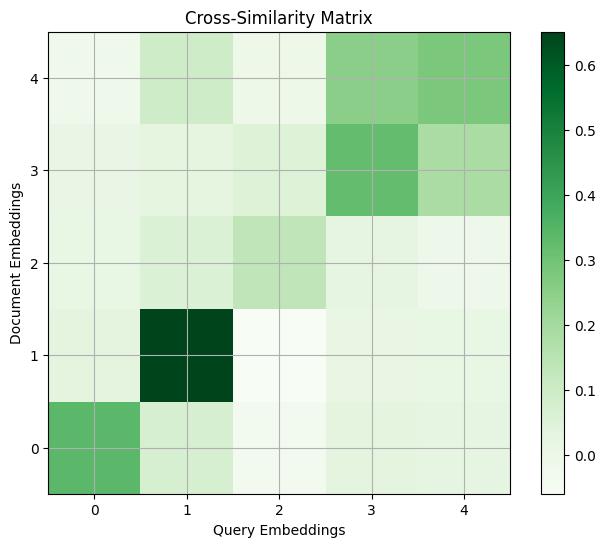

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_cross_similarity_matrix(emb1, emb2):
    # Compute the similarity matrix between embeddings1 and embeddings2
    cross_similarity_matrix = cosine_similarity(np.array(emb1), np.array(emb2))

    # Plotting the cross-similarity matrix
    plt.imshow(cross_similarity_matrix, cmap='Greens', interpolation='nearest')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title("Cross-Similarity Matrix")
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_cross_similarity_matrix(q_embeddings, d_embeddings)
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.show()

# queries = [
#     "What's the weather like in the Rocky Mountains?",
#     "What kinds of food is Italy known for?",
#     "What's my name? I bet you don't remember...",
#     "What's the point of life anyways?",
#     "The point of life is to have fun :D"]
# documents = [
#     "Komchatka's weather is cold, with long, severe winters.",
#     "Italy is famous for pasta, pizza, gelato, and espresso.",
#     "I can't recall personal names, only provide information.",
#     "Life's purpose varies, often seen as personal fulfillment.",
#     "Enjoying life's moments is indeed a wonderful approach."]

----

<br>

## **Part 3: [Exercise]** A Synthetic - But More Realistic - Example

Observe that the entries that could be perceived as good input/output pairs trigger relatively high similarity on embedding. It is worth mentioning that, depending on the encoder model convergence, the query and document pathway may or may not be significantly different:


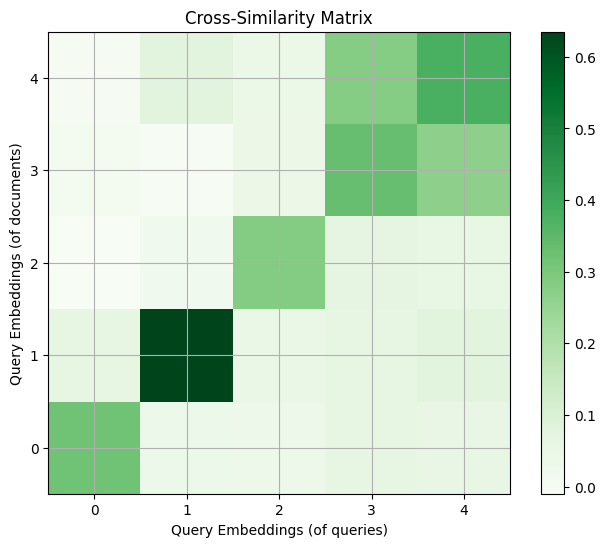

In [8]:
plt.figure(figsize=(8, 6))
plot_cross_similarity_matrix(
    q_embeddings,
    [embedder.embed_query(doc) for doc in documents]
)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Query Embeddings (of documents)")
plt.show()

The real utility of having a "bi-encoder" **in general** is that the second encoder can be trained to remain consistent with the first even if the format of the input starts deviating drastically. To help illustrate this, we can flesh out our documents into longer-form variations and try the same experiment again.

In [10]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

expound_prompt = ChatPromptTemplate.from_template(
    "Generate part of a longer story that could reasonably answer all"
    " of these questions somewhere in its contents: {questions}\n"
    " Make sure the passage only answers the following concretely: {q1}."
    " Give it some weird formatting, and try not to answer the others."
    " Do not include any commentary like 'Here is your response'"
)

###############################################################################################
## BEGIN TODO

expound_chain = (
    ## TODO: flesh out documents into a more verbose form by implementing the expound_chain 
    ##  which takes advantage of the prompt and llm provided above.
    {'q1' : itemgetter(0), 'questions' : itemgetter(1) }  # {}
    | expound_prompt 
    | instruct_llm
    | StrOutputParser()
)

longer_docs = []
for i, q in enumerate(queries):
    ## TODO: Invoke the expound_chain pipeline as appropriate
    longer_doc = expound_chain.invoke([q, queries]) # ""
    pprint(f"\n\n[Query {i+1}]")
    print(q)
    pprint(f"\n\n[Document {i+1}]")
    print(longer_doc)
    pprint("-"*64)
    longer_docs += [longer_doc]

## END TODO
###############################################################################################

[Query 1]

What's the weather like in Rocky Mountains?


[Document 1]

Weather in the Rockies:

* * * * *

The Rocky Mountains, a range known for its rugged peaks and sprawling wilderness, experiences a wide range of weather patterns throughout the year. In the winter, the mountains are often coated in a blanket of snow, making it a popular destination for skiers and snowboarders. The temperature during this time can drop well below freezing, with average lows in the single digits Fahrenheit.

As the spring season approaches, the snow begins to melt, and the rivers and streams that flow through the mountains start to swell. The temperature begins to rise, with average highs in the 50s and 60s Fahrenheit. However, the weather can still be quite unpredictable, and snowstorms are not uncommon in the early spring.

Summer in the Rockies is mild, with average highs in the 70s and 80s Fahrenheit. The mountain air is cool and refreshing, making it a great escape from the heat of the city. However, thunderstorms are common in the afternoons, bringing lightning an

----------------------------------------------------------------

[Query 2]

What kinds of food is Italy known for?


[Document 2]

---

*soft, melodic humming*

//

Italy, known for its rich cultural history and breathtaking landscapes, has contributed greatly to the culinary world. From pasta and pizza to gelato and espresso, Italy has given us many delicious foods to enjoy. The warm, sunny climate in the south is ideal for growing tomatoes, olives, and citrus fruits, while the cooler, mountainous regions in the north produce high-quality dairy products such as cheese and butter.

//

*light finger tapping*

---

(Psst... the answer to "The point of life is to have fun :D" is in there too, hidden among the words.)


----------------------------------------------------------------

[Query 3]

What's my name? I bet you don't remember...


[Document 3]

"By the way," it said, almost as an afterthought, "what's my name? I bet you don't remember."

It had a point, I couldn't deny that. But I didn't want to admit it, so I kept quiet.

"I'll tell you what," it continued, "I'm going to give you a hint. My name is the same as this delicious dish I had in Italy."

I raised an eyebrow, curious despite myself. "Italy? You've been to Italy?"

It chuckled. "Of course I have. I've been all over the place. But that's a story for another time. Let me just say that Italy is known for its incredible food, from pasta to pizza to gelato. But there's one dish in particular that reminds me of home. It's a simple dish, really, but it's full of flavor and warmth. It's called 'osso buco', and it's made with veal shanks braised in vegetables, white wine, and broth. The meat is so tender it falls off the bone, and the sauce is rich and savory. it's absolute heaven."

I sighed, my mind drifting to the rolling hills and charming towns of Italy. "That does sound

----------------------------------------------------------------

[Query 4]

What's the point of life anyways?


[Document 4]

__**=====================**___

The answer you seek lies not in the tangible, but the abstract, the philosophical, the realm of existential pondering. To some, the point of life is as elusive as the meaning behind a dream; to others, as clear as the midday sun.

Yet, I shall provide an answer, as you have asked, and I shall do my best to elucidate, to illuminate this enigma.

The point of life, some say, is to seek happiness, to find joy, to experience pleasure.

Others argue it is to learn, to grow, to evolve, to better oneself.

Still, others propose it is to contribute to the greater good, to make the world a better place, to leave a legacy.

But I have an answer, a simple, yet profound answer that I have found to be the most satisfying.

The point of life is to have fun.

Yes, you read that correctly.

Life, in its essence, is a grand, magnificent game. It is an opportunity to explore, to discover, to experience the vast array of wonders that this universe has to offer.

It is a ch

----------------------------------------------------------------

[Query 5]

The point of life is to have fun :D


[Document 5]

life's purpose: have fun :D

Really think about it: what's the point of doing anything if you're not enjoying yourself? Some people might say the point of life is to be successful or to make a difference in the world, but what's the use of all that success if you're miserable?

Nope, the real key to a fulfilling life is to have fun. Laugh, smile, and enjoy every moment. Find joy in the little things and make time for the things that bring you the most happiness.

So go ahead, live your life with a smile on your face and a spring in your step. Have fun and enjoy the ride.

(And by the way, your name is totally slipping my mind right now. Oops!)

* * *

As for the weather in the Rocky Mountains, I'm afraid I can't give you a straight answer. It's always changing, just like the moods of the people who visit. One minute it's clear and sunny, the next it's pouring rain or snow. But that's all part of the adventure, right?

And as for Italian food, well let's just say it's not exactly my are

----------------------------------------------------------------

-----

When you're happy with the longer-form documents, please run the code below to see how the embeddings compare. The results may be similar, but there is at least some mathematically-optimized relationship that might help improve retrieval results at a larger scale. This result will also vary depending on the bi-encoder model, so keep that in mind.

In general, it's a good idea to default towards using the opposite encoder for its advertised use case and gravitate closer towards using the same encoder when you assume that the things you're comparing are similar in form and modality. To be clear, the deviation for the model we tested was only slightly different between the two options, but it's still a consideration to make.


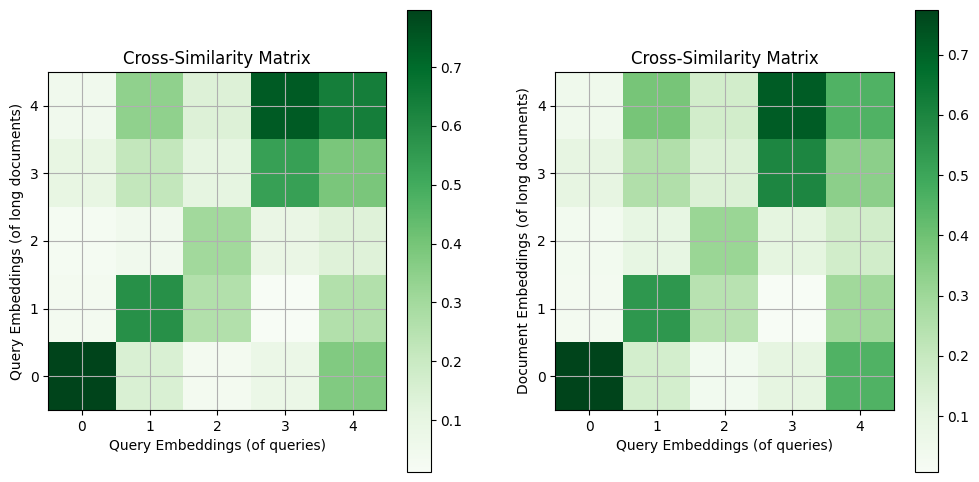

In [11]:
## At the time of writing, our embedding model supports up to 2048 tokens...
longer_docs_cut = [doc[:2048] for doc in longer_docs]

q_long_embs = [embedder._embed([doc], model_type='query')[0] for doc in longer_docs_cut]
d_long_embs = [embedder._embed([doc], model_type='passage')[0] for doc in longer_docs_cut]

## The difference for any particular example may be very small.
## We've raised the similarity matrix to the power of 5 to try and spot a difference.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_cross_similarity_matrix(q_embeddings, q_long_embs)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Query Embeddings (of long documents)")

plt.subplot(1, 2, 2)
plot_cross_similarity_matrix(q_embeddings, d_long_embs)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Document Embeddings (of long documents)")
plt.show()

<br>

**NOTE:** To see two drastically different bi-encoder components, consider checking out the [Contrastive Language-Image Pre-training model (CLIP)](https://openai.com/index/clip/). This bi-encoder pair synergizes over a much wider modality gap to connect the image and text modalities instead of the query and document ones.


----

<br>

## **Part 4: [Exercise]** Embeddings For Semantic Guardrails

In the next notebook, we will start to use higher-level utilities which will take our embedding model and use it under the hood. With that being said, there are several important concepts that can still be explored while the raw methods are still fresh!

Specifically, we can use it as a backbone for a critical component of productionalized models: **semantic guardrailing**. Specifically, we can use the embeddings to filter out messages that are unlikely to be useful (or are actively harmful) for our chatbot to answer!

**This exercise has been segmented into [**`64_guardrails.ipynb`**](64_guardrails.ipynb).**

-----

## **Part 5:** Wrap-Up

By the end of this notebook, you should be familiar with the value proposition of a semantic embedding model and understand how we can use it to search through a dataset for relevant information!

### <font color="#76b900">**Great Job!**</font>

### **Next Steps:**
1. **[Optional]** Revisit the **"Questions To Think About" Section** at the top of the notebook and think about some possible answers.
2. **[Advanced]** If you have the time, please check out and try to complete the **Notebook 6.4**, which covers semantic guardrails.
3. Continue to the next video, which will discuss **Retrieval with Vectorstores**.
4. After the video, go on to the corresponding notebook on **Retrieval with Vectorstores**.

---

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>